In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from IPython import display


import fnmatch

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))

In [3]:
notes = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', notes)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


In [4]:
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/notes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 30828
Number of examples per label: 2318
Example file tensor: tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\en027a_55.wav', shape=(), dtype=string)


In [5]:
filenames = filenames[:28000]

train_files = filenames[:19600]
val_files = filenames[19600: 19600 + 5600]
test_files = filenames[-2800:]

print('Размер обучающего набора', len(train_files))
print('Размер проверочного набора', len(val_files))
print('Размер тестового набора', len(test_files))

Размер обучающего набора 19600
Размер проверочного набора 5600
Размер тестового набора 2800


In [6]:
# После разделения изначальных аудио-файлов на ноты все получившиеся записи стали моно-записями
test_file = tf.io.read_file(filenames[0])
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([11506, 1])

In [7]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary) # возвращает WAV-кодированные как Тензор и частотой дискретизации.
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # Примечание. Здесь будет использоваться индексирование вместо распаковки кортежей, 
    # чтобы это работало на графике TensorFlow.
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def without_zero_len(waveform, label):
    if len(waveform)!=0:  
        return True
    return False

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
count = 0
for a,_ in waveform_ds:
    count+=1
    if a.shape[0]==0:
        print(count, filenames[count])
waveform_ds = waveform_ds.filter(without_zero_len) # Удаляем сигналы нулевой длины

1171 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en045a_5.wav', shape=(), dtype=string)
2199 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en022b_76.wav', shape=(), dtype=string)
4355 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en049a_84.wav', shape=(), dtype=string)
4425 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\E\\kr021b_42.wav', shape=(), dtype=string)
8201 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\kr002b_204.wav', shape=(), dtype=string)
9690 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D#\\kr038b_134.wav', shape=(), dtype=string)
12707 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\D\\kr019a_8.wav', shape=(), dtype=string)
14965 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\F#\\en012b_80.wav', shape=(), dtype=string)
17485 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\C#\\kr005b_65.wav', shape=(), dtype=string)
19349 tf.Tensor(b'D:\\magistracy\\diplom\\records_cut\\G\\en031a_54.wav', shape=(), dtype=string)


In [9]:
# Загружаем триангулярные фильтры
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank.shape)

(1025, 40)


In [10]:
def get_spectrogram(params):
    waveform = params[0]
    S = tf.convert_to_tensor(params[1])
    NFFT = 2048
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S,pad_end=True)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров

    return spectrogram

In [11]:
def get_spectrogram_and_label_id(audio, label, step):
    spectrogram = get_spectrogram((audio,step))
    #spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == notes)
    return spectrogram, label_id

def get_spectrogram_and_label_id_lim(spectrogram, label_id, M):
    spec_length = len(spectrogram)
    if spec_length<M:
        for k in range(M-spec_length):
            spect_last = spectrogram[spec_length-1]
            spect_last = tf.expand_dims(spect_last, 0)
            spectrogram = tf.concat([spectrogram, spect_last], 0)
    elif spec_length>M:
        start = tf.random.uniform(shape=[], minval=0, maxval=spec_length-M, dtype=tf.int32)
        spectrogram = spectrogram[start:start+M]
    else:
        spectrogram = spectrogram
    return spectrogram, label_id

In [12]:
step = list(map(int,[2048/32, 2048/16, 2048/8, 2048/4, 2048/2, 2048]))
num_frame = [5,10,15,20,25,30]
params_s_f = [] 

for s in step:
    for f in num_frame:
        params_s_f.append((s,f))
print('Количество вариантов step', len(step))
print('Количество вариантов num_frame', len(num_frame))
print('Количество баз данных', len(params_s_f))

Количество вариантов step 6
Количество вариантов num_frame 6
Количество баз данных 36


In [13]:
params_s_f

[(64, 5),
 (64, 10),
 (64, 15),
 (64, 20),
 (64, 25),
 (64, 30),
 (128, 5),
 (128, 10),
 (128, 15),
 (128, 20),
 (128, 25),
 (128, 30),
 (256, 5),
 (256, 10),
 (256, 15),
 (256, 20),
 (256, 25),
 (256, 30),
 (512, 5),
 (512, 10),
 (512, 15),
 (512, 20),
 (512, 25),
 (512, 30),
 (1024, 5),
 (1024, 10),
 (1024, 15),
 (1024, 20),
 (1024, 25),
 (1024, 30),
 (2048, 5),
 (2048, 10),
 (2048, 15),
 (2048, 20),
 (2048, 25),
 (2048, 30)]

In [14]:
def preprocess_dataset(files,s,f):
    files_ds = tf.data.Dataset.from_tensor_slices(train_files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.filter(without_zero_len) 
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,s), num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,f))
    return output_ds

In [15]:
def create_model(input_shape):
    inputs = layers.Input(shape = input_shape, name = "inputs")
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation = 'relu', name = "relu_1")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_2")(x)
    x = layers.Dense(512, activation = 'relu', name = "relu_3")(x)
    outputs = layers.Dense(12,activation = 'softmax', name = "dense_end")(x)
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [25]:
import time
EPOCHS = 100
models = []
histories = []

In [26]:
start_time0 = time.time()
tests_acc = []
for k in range(len(params_s_f)):
    print('---------------------------------------------------------------------')
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1])
    train_ds = []
    val_ds = []
    test_ds = []
    spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k][0]), num_parallel_calls=AUTOTUNE)
    spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k][1]))
    train_ds = spectrogram_ds
    val_ds = preprocess_dataset(val_files,params_s_f[k][0],params_s_f[k][1])
    test_ds = preprocess_dataset(test_files,params_s_f[k][0],params_s_f[k][1])
    
    batch_size = 64
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    test_audio = []
    test_labels = []

    for audio, label in test_ds:
        test_audio.append(audio.numpy())
        test_labels.append(label.numpy())

    test_audio = np.array(test_audio)
    test_labels = np.array(test_labels)

    for spectrogram, _ in spectrogram_ds.take(1):
        input_shape = spectrogram.shape
        print('input_shape',input_shape)
    
    
    mymodel = create_model(input_shape)
    
    start_time = time.time()
    myhistory = mymodel.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
    minutes, seconds = ((time.time() - start_time) - 3600 * ((time.time() - start_time) // 3600)) // 60, (time.time() - start_time) % 60
    print(f"--- {minutes} минут {seconds} секунд ---")
    
    metrics = myhistory.history
    y_pred = np.argmax(mymodel.predict(test_audio), axis=1)
    y_true = test_labels
    test_acc = sum(y_pred == y_true) / len(y_true) * 100
    tests_acc.append(test_acc)
    print('Шаг:', params_s_f[k][0], ', количество спектрограмм: ',params_s_f[k][1], ', accuracy тестовой выборки: ', test_acc, '%')
    models.append(mymodel)
    histories.append(myhistory)
    
    
minutes, seconds = ((time.time() - start_time0) - 3600 * ((time.time() - start_time0) // 3600)) // 60, (time.time() - start_time0) % 60    
print(f"--- {minutes} минут {seconds} секунд ---")

---------------------------------------------------------------------
Шаг: 64 , количество спектрограмм:  5
input_shape (5, 40)
Epoch 1/100
307/307 [==============================] - 102s 333ms/step - loss: 1.3235 - accuracy: 0.5815 - val_loss: 1.1427 - val_accuracy: 0.6041
Epoch 2/100
307/307 [==============================] - 2s 7ms/step - loss: 0.9741 - accuracy: 0.6773 - val_loss: 1.0663 - val_accuracy: 0.6319
Epoch 3/100
307/307 [==============================] - 2s 7ms/step - loss: 0.9293 - accuracy: 0.6981 - val_loss: 0.9285 - val_accuracy: 0.6870
Epoch 4/100
307/307 [==============================] - 2s 7ms/step - loss: 0.8949 - accuracy: 0.7106 - val_loss: 0.8835 - val_accuracy: 0.7084
Epoch 5/100
307/307 [==============================] - 2s 7ms/step - loss: 0.8754 - accuracy: 0.7168 - val_loss: 0.9352 - val_accuracy: 0.6875
Epoch 6/100
307/307 [==============================] - 2s 7ms/step - loss: 0.8666 - accuracy: 0.7194 - val_loss: 0.9590 - val_accuracy: 0.6787
Epoch 7/10

307/307 [==============================] - 2s 7ms/step - loss: 0.5621 - accuracy: 0.8049 - val_loss: 1.0567 - val_accuracy: 0.7270
Epoch 58/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5718 - accuracy: 0.8009 - val_loss: 0.9454 - val_accuracy: 0.7399
Epoch 59/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5871 - accuracy: 0.7954 - val_loss: 0.9786 - val_accuracy: 0.7358
Epoch 60/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5944 - accuracy: 0.7934 - val_loss: 0.9550 - val_accuracy: 0.7410
Epoch 61/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5877 - accuracy: 0.7944 - val_loss: 0.9388 - val_accuracy: 0.7352
Epoch 62/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5500 - accuracy: 0.8075 - val_loss: 0.9192 - val_accuracy: 0.7373
Epoch 63/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5392 - accuracy: 0.8136 - val_loss: 0.8710 - val_accuracy: 0.7401
Epoch

307/307 [==============================] - 2s 7ms/step - loss: 0.7916 - accuracy: 0.7449 - val_loss: 0.8310 - val_accuracy: 0.7302
Epoch 13/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7684 - accuracy: 0.7565 - val_loss: 0.7978 - val_accuracy: 0.7419
Epoch 14/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7682 - accuracy: 0.7540 - val_loss: 0.7632 - val_accuracy: 0.7586
Epoch 15/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7532 - accuracy: 0.7582 - val_loss: 0.7769 - val_accuracy: 0.7501
Epoch 16/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7525 - accuracy: 0.7594 - val_loss: 0.7550 - val_accuracy: 0.7588
Epoch 17/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7448 - accuracy: 0.7619 - val_loss: 0.7741 - val_accuracy: 0.7527
Epoch 18/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7405 - accuracy: 0.7614 - val_loss: 0.7698 - val_accuracy: 0.7554
Epoch

Epoch 69/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5373 - accuracy: 0.8108 - val_loss: 0.9447 - val_accuracy: 0.7450
Epoch 70/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5488 - accuracy: 0.8119 - val_loss: 0.9956 - val_accuracy: 0.7357
Epoch 71/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5401 - accuracy: 0.8184 - val_loss: 0.8876 - val_accuracy: 0.7482
Epoch 72/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5642 - accuracy: 0.8080 - val_loss: 0.8513 - val_accuracy: 0.7423
Epoch 73/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5490 - accuracy: 0.8126 - val_loss: 0.8180 - val_accuracy: 0.7573
Epoch 74/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5513 - accuracy: 0.8106 - val_loss: 1.0047 - val_accuracy: 0.7274
Epoch 75/100
307/307 [==============================] - 2s 7ms/step - loss: 0.5436 - accuracy: 0.8154 - val_loss: 0.9650 - val_accuracy:

307/307 [==============================] - 2s 8ms/step - loss: 0.6881 - accuracy: 0.7768 - val_loss: 0.7867 - val_accuracy: 0.7478
Epoch 25/100
307/307 [==============================] - 2s 8ms/step - loss: 0.6931 - accuracy: 0.7747 - val_loss: 0.8214 - val_accuracy: 0.7465
Epoch 26/100
307/307 [==============================] - 2s 8ms/step - loss: 0.6960 - accuracy: 0.7746 - val_loss: 0.7921 - val_accuracy: 0.7611
Epoch 27/100
307/307 [==============================] - 2s 8ms/step - loss: 0.6964 - accuracy: 0.7752 - val_loss: 0.7316 - val_accuracy: 0.7663
Epoch 28/100
307/307 [==============================] - 2s 8ms/step - loss: 0.6882 - accuracy: 0.7769 - val_loss: 0.7285 - val_accuracy: 0.7698
Epoch 29/100
307/307 [==============================] - 2s 8ms/step - loss: 0.6704 - accuracy: 0.7799 - val_loss: 0.7660 - val_accuracy: 0.7542
Epoch 30/100
307/307 [==============================] - 2s 8ms/step - loss: 0.6752 - accuracy: 0.7813 - val_loss: 0.7381 - val_accuracy: 0.7666
Epoch

Epoch 81/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5421 - accuracy: 0.8145 - val_loss: 0.9087 - val_accuracy: 0.7581
Epoch 82/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5360 - accuracy: 0.8196 - val_loss: 0.8823 - val_accuracy: 0.7613
Epoch 83/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5197 - accuracy: 0.8221 - val_loss: 0.9477 - val_accuracy: 0.7481
Epoch 84/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5336 - accuracy: 0.8189 - val_loss: 0.9580 - val_accuracy: 0.7405
Epoch 85/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5220 - accuracy: 0.8206 - val_loss: 0.9260 - val_accuracy: 0.7599
Epoch 86/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5231 - accuracy: 0.8208 - val_loss: 0.9763 - val_accuracy: 0.7591
Epoch 87/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5252 - accuracy: 0.8217 - val_loss: 0.9874 - val_accuracy:

307/307 [==============================] - 3s 8ms/step - loss: 0.6310 - accuracy: 0.7953 - val_loss: 0.6740 - val_accuracy: 0.7847
Epoch 37/100
307/307 [==============================] - 3s 8ms/step - loss: 0.6355 - accuracy: 0.7922 - val_loss: 0.6645 - val_accuracy: 0.7903
Epoch 38/100
307/307 [==============================] - 3s 8ms/step - loss: 0.6057 - accuracy: 0.8003 - val_loss: 0.6941 - val_accuracy: 0.7823
Epoch 39/100
307/307 [==============================] - 3s 8ms/step - loss: 0.6014 - accuracy: 0.8015 - val_loss: 0.6767 - val_accuracy: 0.7818
Epoch 40/100
307/307 [==============================] - 3s 8ms/step - loss: 0.6258 - accuracy: 0.7940 - val_loss: 0.7036 - val_accuracy: 0.7807
Epoch 41/100
307/307 [==============================] - 2s 8ms/step - loss: 0.6199 - accuracy: 0.7955 - val_loss: 0.6574 - val_accuracy: 0.7938
Epoch 42/100
307/307 [==============================] - 3s 8ms/step - loss: 0.6019 - accuracy: 0.8004 - val_loss: 0.7227 - val_accuracy: 0.7753
Epoch

Epoch 93/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5094 - accuracy: 0.8307 - val_loss: 0.8033 - val_accuracy: 0.7801
Epoch 94/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5299 - accuracy: 0.8232 - val_loss: 0.8621 - val_accuracy: 0.7721
Epoch 95/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5130 - accuracy: 0.8266 - val_loss: 0.8185 - val_accuracy: 0.7859
Epoch 96/100
307/307 [==============================] - 2s 8ms/step - loss: 0.4898 - accuracy: 0.8350 - val_loss: 0.8376 - val_accuracy: 0.7881
Epoch 97/100
307/307 [==============================] - 3s 8ms/step - loss: 0.5178 - accuracy: 0.8279 - val_loss: 0.8402 - val_accuracy: 0.7887
Epoch 98/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5114 - accuracy: 0.8311 - val_loss: 0.7999 - val_accuracy: 0.7954
Epoch 99/100
307/307 [==============================] - 3s 8ms/step - loss: 0.4927 - accuracy: 0.8352 - val_loss: 0.7992 - val_accuracy:

307/307 [==============================] - 3s 8ms/step - loss: 0.5477 - accuracy: 0.8244 - val_loss: 0.6812 - val_accuracy: 0.7986
Epoch 49/100
307/307 [==============================] - 3s 8ms/step - loss: 0.5374 - accuracy: 0.8260 - val_loss: 0.6715 - val_accuracy: 0.7977
Epoch 50/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5520 - accuracy: 0.8194 - val_loss: 0.6597 - val_accuracy: 0.8034
Epoch 51/100
307/307 [==============================] - 3s 8ms/step - loss: 0.5273 - accuracy: 0.8264 - val_loss: 0.6655 - val_accuracy: 0.7990
Epoch 52/100
307/307 [==============================] - 3s 8ms/step - loss: 0.5365 - accuracy: 0.8248 - val_loss: 0.7154 - val_accuracy: 0.7837
Epoch 53/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5320 - accuracy: 0.8249 - val_loss: 0.7442 - val_accuracy: 0.7677
Epoch 54/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5362 - accuracy: 0.8251 - val_loss: 0.6812 - val_accuracy: 0.7861
Epoch

307/307 [==============================] - 3s 9ms/step - loss: 0.8019 - accuracy: 0.7412 - val_loss: 0.8859 - val_accuracy: 0.7025
Epoch 4/100
307/307 [==============================] - 3s 9ms/step - loss: 0.7851 - accuracy: 0.7453 - val_loss: 0.7720 - val_accuracy: 0.7430
Epoch 5/100
307/307 [==============================] - 3s 9ms/step - loss: 0.7544 - accuracy: 0.7579 - val_loss: 0.8304 - val_accuracy: 0.7181
Epoch 6/100
307/307 [==============================] - 3s 9ms/step - loss: 0.7303 - accuracy: 0.7666 - val_loss: 0.8210 - val_accuracy: 0.7333
Epoch 7/100
307/307 [==============================] - 3s 9ms/step - loss: 0.7370 - accuracy: 0.7635 - val_loss: 0.6720 - val_accuracy: 0.7873
Epoch 8/100
307/307 [==============================] - 3s 9ms/step - loss: 0.7048 - accuracy: 0.7766 - val_loss: 0.7026 - val_accuracy: 0.7701
Epoch 9/100
307/307 [==============================] - 3s 9ms/step - loss: 0.6847 - accuracy: 0.7826 - val_loss: 0.7076 - val_accuracy: 0.7705
Epoch 10/10

307/307 [==============================] - 3s 9ms/step - loss: 0.5183 - accuracy: 0.8319 - val_loss: 0.5629 - val_accuracy: 0.8237
Epoch 61/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5168 - accuracy: 0.8319 - val_loss: 0.6012 - val_accuracy: 0.8137
Epoch 62/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5023 - accuracy: 0.8362 - val_loss: 0.5615 - val_accuracy: 0.8233
Epoch 63/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5026 - accuracy: 0.8356 - val_loss: 0.5855 - val_accuracy: 0.8212
Epoch 64/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4968 - accuracy: 0.8370 - val_loss: 0.6534 - val_accuracy: 0.8077
Epoch 65/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4960 - accuracy: 0.8380 - val_loss: 0.7017 - val_accuracy: 0.7889
Epoch 66/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5344 - accuracy: 0.8285 - val_loss: 0.6307 - val_accuracy: 0.8029
Epoch

307/307 [==============================] - 2s 7ms/step - loss: 0.7397 - accuracy: 0.7590 - val_loss: 0.8436 - val_accuracy: 0.7346
Epoch 16/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7372 - accuracy: 0.7591 - val_loss: 0.7859 - val_accuracy: 0.7441
Epoch 17/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7280 - accuracy: 0.7630 - val_loss: 0.8364 - val_accuracy: 0.7395
Epoch 18/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7268 - accuracy: 0.7630 - val_loss: 0.8242 - val_accuracy: 0.7454
Epoch 19/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7171 - accuracy: 0.7663 - val_loss: 0.8297 - val_accuracy: 0.7506
Epoch 20/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7039 - accuracy: 0.7692 - val_loss: 0.8084 - val_accuracy: 0.7570
Epoch 21/100
307/307 [==============================] - 2s 7ms/step - loss: 0.7058 - accuracy: 0.7674 - val_loss: 0.7671 - val_accuracy: 0.7517
Epoch

Epoch 72/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4902 - accuracy: 0.8315 - val_loss: 0.8769 - val_accuracy: 0.7595
Epoch 73/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4750 - accuracy: 0.8330 - val_loss: 0.9880 - val_accuracy: 0.7488
Epoch 74/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4807 - accuracy: 0.8342 - val_loss: 1.0817 - val_accuracy: 0.7378
Epoch 75/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4432 - accuracy: 0.8446 - val_loss: 0.9314 - val_accuracy: 0.7539
Epoch 76/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4383 - accuracy: 0.8462 - val_loss: 0.9736 - val_accuracy: 0.7445
Epoch 77/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4247 - accuracy: 0.8518 - val_loss: 1.1890 - val_accuracy: 0.7317
Epoch 78/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4512 - accuracy: 0.8423 - val_loss: 1.0781 - val_accuracy:

307/307 [==============================] - 2s 7ms/step - loss: 0.6442 - accuracy: 0.7898 - val_loss: 0.7430 - val_accuracy: 0.7683
Epoch 28/100
307/307 [==============================] - 2s 7ms/step - loss: 0.6450 - accuracy: 0.7897 - val_loss: 0.8456 - val_accuracy: 0.7359
Epoch 29/100
307/307 [==============================] - 2s 7ms/step - loss: 0.6488 - accuracy: 0.7870 - val_loss: 0.7617 - val_accuracy: 0.7647
Epoch 30/100
307/307 [==============================] - 2s 7ms/step - loss: 0.6436 - accuracy: 0.7885 - val_loss: 0.7903 - val_accuracy: 0.7637
Epoch 31/100
307/307 [==============================] - 2s 7ms/step - loss: 0.6317 - accuracy: 0.7927 - val_loss: 0.7426 - val_accuracy: 0.7754
Epoch 32/100
307/307 [==============================] - 2s 7ms/step - loss: 0.6271 - accuracy: 0.7931 - val_loss: 0.7567 - val_accuracy: 0.7608
Epoch 33/100
307/307 [==============================] - 2s 7ms/step - loss: 0.6245 - accuracy: 0.7926 - val_loss: 0.7585 - val_accuracy: 0.7603
Epoch

Epoch 84/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4924 - accuracy: 0.8346 - val_loss: 1.0741 - val_accuracy: 0.7545
Epoch 85/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4758 - accuracy: 0.8409 - val_loss: 0.9989 - val_accuracy: 0.7510
Epoch 86/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4490 - accuracy: 0.8475 - val_loss: 0.8758 - val_accuracy: 0.7699
Epoch 87/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4365 - accuracy: 0.8517 - val_loss: 1.0015 - val_accuracy: 0.7559
Epoch 88/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4310 - accuracy: 0.8526 - val_loss: 1.2023 - val_accuracy: 0.7293
Epoch 89/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4541 - accuracy: 0.8468 - val_loss: 1.0996 - val_accuracy: 0.7505
Epoch 90/100
307/307 [==============================] - 2s 7ms/step - loss: 0.4539 - accuracy: 0.8464 - val_loss: 1.3684 - val_accuracy:

307/307 [==============================] - 3s 8ms/step - loss: 0.5043 - accuracy: 0.8313 - val_loss: 0.6336 - val_accuracy: 0.8064
Epoch 40/100
307/307 [==============================] - 3s 8ms/step - loss: 0.5254 - accuracy: 0.8257 - val_loss: 0.6661 - val_accuracy: 0.7989
Epoch 41/100
307/307 [==============================] - 3s 8ms/step - loss: 0.5111 - accuracy: 0.8276 - val_loss: 0.6431 - val_accuracy: 0.8028
Epoch 42/100
307/307 [==============================] - 2s 8ms/step - loss: 0.5002 - accuracy: 0.8330 - val_loss: 0.6436 - val_accuracy: 0.8076
Epoch 43/100
307/307 [==============================] - 3s 8ms/step - loss: 0.5038 - accuracy: 0.8299 - val_loss: 0.6942 - val_accuracy: 0.7971
Epoch 44/100
307/307 [==============================] - 3s 8ms/step - loss: 0.4910 - accuracy: 0.8356 - val_loss: 0.6348 - val_accuracy: 0.8153
Epoch 45/100
307/307 [==============================] - 3s 8ms/step - loss: 0.4747 - accuracy: 0.8377 - val_loss: 0.6681 - val_accuracy: 0.7995
Epoch

Epoch 96/100
307/307 [==============================] - 3s 8ms/step - loss: 0.3805 - accuracy: 0.8721 - val_loss: 0.8321 - val_accuracy: 0.7899
Epoch 97/100
307/307 [==============================] - 3s 8ms/step - loss: 0.3659 - accuracy: 0.8769 - val_loss: 0.9356 - val_accuracy: 0.7819
Epoch 98/100
307/307 [==============================] - 3s 8ms/step - loss: 0.3482 - accuracy: 0.8822 - val_loss: 1.0826 - val_accuracy: 0.7538
Epoch 99/100
307/307 [==============================] - 3s 8ms/step - loss: 0.3619 - accuracy: 0.8767 - val_loss: 0.8372 - val_accuracy: 0.7807
Epoch 100/100
307/307 [==============================] - 3s 8ms/step - loss: 0.3870 - accuracy: 0.8689 - val_loss: 0.9000 - val_accuracy: 0.7961
--- 5.0 минут 9.419497728347778 секунд ---
Шаг: 128 , количество спектрограмм:  15 , accuracy тестовой выборки:  79.60694231750894 %
---------------------------------------------------------------------
Шаг: 128 , количество спектрограмм:  20
input_shape (20, 40)
Epoch 1/100
307

Epoch 51/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4583 - accuracy: 0.8487 - val_loss: 0.6612 - val_accuracy: 0.8092
Epoch 52/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4518 - accuracy: 0.8498 - val_loss: 0.6676 - val_accuracy: 0.8051
Epoch 53/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4451 - accuracy: 0.8535 - val_loss: 0.6797 - val_accuracy: 0.8063
Epoch 54/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4325 - accuracy: 0.8568 - val_loss: 0.6347 - val_accuracy: 0.8132
Epoch 55/100
307/307 [==============================] - 4s 12ms/step - loss: 0.4475 - accuracy: 0.8514 - val_loss: 0.6678 - val_accuracy: 0.7982
Epoch 56/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4259 - accuracy: 0.8589 - val_loss: 0.6421 - val_accuracy: 0.8059
Epoch 57/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4146 - accuracy: 0.8605 - val_loss: 0.5580 - val_ac

Epoch 6/100
307/307 [==============================] - 4s 13ms/step - loss: 0.6094 - accuracy: 0.8087 - val_loss: 0.6424 - val_accuracy: 0.7959
Epoch 7/100
307/307 [==============================] - 4s 13ms/step - loss: 0.5963 - accuracy: 0.8154 - val_loss: 0.6293 - val_accuracy: 0.7987
Epoch 8/100
307/307 [==============================] - 4s 13ms/step - loss: 0.5861 - accuracy: 0.8158 - val_loss: 0.5415 - val_accuracy: 0.8280
Epoch 9/100
307/307 [==============================] - 4s 13ms/step - loss: 0.5882 - accuracy: 0.8134 - val_loss: 0.5631 - val_accuracy: 0.8207
Epoch 10/100
307/307 [==============================] - 4s 13ms/step - loss: 0.5643 - accuracy: 0.8240 - val_loss: 0.5575 - val_accuracy: 0.8250
Epoch 11/100
307/307 [==============================] - 4s 13ms/step - loss: 0.5609 - accuracy: 0.8225 - val_loss: 0.5424 - val_accuracy: 0.8287
Epoch 12/100
307/307 [==============================] - 4s 13ms/step - loss: 0.5492 - accuracy: 0.8253 - val_loss: 0.5659 - val_accura

307/307 [==============================] - 4s 13ms/step - loss: 0.3756 - accuracy: 0.8743 - val_loss: 0.6241 - val_accuracy: 0.8215
Epoch 63/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3946 - accuracy: 0.8716 - val_loss: 0.6112 - val_accuracy: 0.8259
Epoch 64/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3796 - accuracy: 0.8775 - val_loss: 0.5400 - val_accuracy: 0.8435
Epoch 65/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3968 - accuracy: 0.8705 - val_loss: 0.5720 - val_accuracy: 0.8382
Epoch 66/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3860 - accuracy: 0.8738 - val_loss: 0.5331 - val_accuracy: 0.8479
Epoch 67/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3933 - accuracy: 0.8704 - val_loss: 0.5589 - val_accuracy: 0.8501
Epoch 68/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3728 - accuracy: 0.8760 - val_loss: 0.5347 - val_accuracy: 0.853

Epoch 17/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4882 - accuracy: 0.8470 - val_loss: 0.4561 - val_accuracy: 0.8584
Epoch 18/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4874 - accuracy: 0.8474 - val_loss: 0.4717 - val_accuracy: 0.8474
Epoch 19/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4878 - accuracy: 0.8466 - val_loss: 0.6179 - val_accuracy: 0.8014
Epoch 20/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4838 - accuracy: 0.8500 - val_loss: 0.5359 - val_accuracy: 0.8240
Epoch 21/100
307/307 [==============================] - 4s 14ms/step - loss: 0.4713 - accuracy: 0.8499 - val_loss: 0.6218 - val_accuracy: 0.7959
Epoch 22/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4773 - accuracy: 0.8486 - val_loss: 0.5094 - val_accuracy: 0.8415
Epoch 23/100
307/307 [==============================] - 4s 13ms/step - loss: 0.4689 - accuracy: 0.8503 - val_loss: 0.5540 - val_ac

307/307 [==============================] - 4s 13ms/step - loss: 0.3177 - accuracy: 0.8966 - val_loss: 0.5200 - val_accuracy: 0.8586
Epoch 74/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3103 - accuracy: 0.8987 - val_loss: 0.5610 - val_accuracy: 0.8574
Epoch 75/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3027 - accuracy: 0.9001 - val_loss: 0.4631 - val_accuracy: 0.8755
Epoch 76/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2955 - accuracy: 0.9015 - val_loss: 0.4905 - val_accuracy: 0.8697
Epoch 77/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2978 - accuracy: 0.9019 - val_loss: 0.4730 - val_accuracy: 0.8718
Epoch 78/100
307/307 [==============================] - 4s 13ms/step - loss: 0.3108 - accuracy: 0.8962 - val_loss: 0.4598 - val_accuracy: 0.8730
Epoch 79/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2912 - accuracy: 0.9018 - val_loss: 0.4728 - val_accuracy: 0.871

307/307 [==============================] - 3s 9ms/step - loss: 0.6123 - accuracy: 0.7982 - val_loss: 0.6799 - val_accuracy: 0.7883
Epoch 29/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5892 - accuracy: 0.8039 - val_loss: 0.6856 - val_accuracy: 0.7856
Epoch 30/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5727 - accuracy: 0.8078 - val_loss: 0.6775 - val_accuracy: 0.7900
Epoch 31/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5494 - accuracy: 0.8177 - val_loss: 0.7119 - val_accuracy: 0.7815
Epoch 32/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5497 - accuracy: 0.8141 - val_loss: 0.7264 - val_accuracy: 0.7785
Epoch 33/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5582 - accuracy: 0.8126 - val_loss: 0.7372 - val_accuracy: 0.7755
Epoch 34/100
307/307 [==============================] - 3s 9ms/step - loss: 0.5470 - accuracy: 0.8163 - val_loss: 0.7360 - val_accuracy: 0.7833
Epoch

Epoch 85/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4002 - accuracy: 0.8630 - val_loss: 1.0155 - val_accuracy: 0.7642
Epoch 86/100
307/307 [==============================] - 3s 9ms/step - loss: 0.3872 - accuracy: 0.8681 - val_loss: 0.9160 - val_accuracy: 0.7829
Epoch 87/100
307/307 [==============================] - 3s 9ms/step - loss: 0.3766 - accuracy: 0.8699 - val_loss: 0.9914 - val_accuracy: 0.7642
Epoch 88/100
307/307 [==============================] - 3s 9ms/step - loss: 0.3794 - accuracy: 0.8712 - val_loss: 0.9954 - val_accuracy: 0.7579
Epoch 89/100
307/307 [==============================] - 3s 9ms/step - loss: 0.3595 - accuracy: 0.8743 - val_loss: 1.0101 - val_accuracy: 0.7684
Epoch 90/100
307/307 [==============================] - 3s 9ms/step - loss: 0.3799 - accuracy: 0.8688 - val_loss: 1.0019 - val_accuracy: 0.7628
Epoch 91/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4005 - accuracy: 0.8622 - val_loss: 0.9904 - val_accuracy:

307/307 [==============================] - 3s 9ms/step - loss: 0.4602 - accuracy: 0.8460 - val_loss: 0.6841 - val_accuracy: 0.8182
Epoch 41/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4431 - accuracy: 0.8528 - val_loss: 0.7053 - val_accuracy: 0.8080
Epoch 42/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4364 - accuracy: 0.8542 - val_loss: 0.6990 - val_accuracy: 0.8115
Epoch 43/100
307/307 [==============================] - 3s 10ms/step - loss: 0.4328 - accuracy: 0.8545 - val_loss: 0.7662 - val_accuracy: 0.8055
Epoch 44/100
307/307 [==============================] - 3s 10ms/step - loss: 0.4225 - accuracy: 0.8600 - val_loss: 0.6490 - val_accuracy: 0.8198
Epoch 45/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4207 - accuracy: 0.8601 - val_loss: 0.6648 - val_accuracy: 0.8255
Epoch 46/100
307/307 [==============================] - 3s 9ms/step - loss: 0.4162 - accuracy: 0.8613 - val_loss: 0.6417 - val_accuracy: 0.8208
Epo

Epoch 97/100
307/307 [==============================] - 3s 9ms/step - loss: 0.2814 - accuracy: 0.9037 - val_loss: 1.2639 - val_accuracy: 0.7813
Epoch 98/100
307/307 [==============================] - 3s 9ms/step - loss: 0.2685 - accuracy: 0.9090 - val_loss: 1.1647 - val_accuracy: 0.7779
Epoch 99/100
307/307 [==============================] - 3s 9ms/step - loss: 0.2998 - accuracy: 0.9016 - val_loss: 1.0632 - val_accuracy: 0.8009
Epoch 100/100
307/307 [==============================] - 3s 9ms/step - loss: 0.2684 - accuracy: 0.9096 - val_loss: 1.3328 - val_accuracy: 0.7775
--- 5.0 минут 16.86199641227722 секунд ---
Шаг: 256 , количество спектрограмм:  10 , accuracy тестовой выборки:  77.75395610005104 %
---------------------------------------------------------------------
Шаг: 256 , количество спектрограмм:  15
input_shape (15, 40)
Epoch 1/100
307/307 [==============================] - 32s 105ms/step - loss: 1.5174 - accuracy: 0.6309 - val_loss: 1.2546 - val_accuracy: 0.6295
Epoch 2/100
3

Epoch 52/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3449 - accuracy: 0.8857 - val_loss: 0.5206 - val_accuracy: 0.8420
Epoch 53/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3684 - accuracy: 0.8798 - val_loss: 0.5208 - val_accuracy: 0.8524
Epoch 54/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3347 - accuracy: 0.8882 - val_loss: 0.5191 - val_accuracy: 0.8508
Epoch 55/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3352 - accuracy: 0.8887 - val_loss: 0.4662 - val_accuracy: 0.8655
Epoch 56/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3368 - accuracy: 0.8891 - val_loss: 0.4731 - val_accuracy: 0.8584
Epoch 57/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3226 - accuracy: 0.8893 - val_loss: 0.5455 - val_accuracy: 0.8412
Epoch 58/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3167 - accuracy: 0.8942 - val_loss: 0.5209 - val_ac

Epoch 7/100
307/307 [==============================] - 3s 11ms/step - loss: 0.4859 - accuracy: 0.8518 - val_loss: 0.4406 - val_accuracy: 0.8670
Epoch 8/100
307/307 [==============================] - 3s 11ms/step - loss: 0.4817 - accuracy: 0.8525 - val_loss: 0.4558 - val_accuracy: 0.8584
Epoch 9/100
307/307 [==============================] - 3s 11ms/step - loss: 0.4589 - accuracy: 0.8610 - val_loss: 0.4254 - val_accuracy: 0.8755
Epoch 10/100
307/307 [==============================] - 3s 11ms/step - loss: 0.4448 - accuracy: 0.8656 - val_loss: 0.4103 - val_accuracy: 0.8798
Epoch 11/100
307/307 [==============================] - 3s 11ms/step - loss: 0.4371 - accuracy: 0.8657 - val_loss: 0.5180 - val_accuracy: 0.8258
Epoch 12/100
307/307 [==============================] - 3s 11ms/step - loss: 0.4229 - accuracy: 0.8687 - val_loss: 0.4726 - val_accuracy: 0.8492
Epoch 13/100
307/307 [==============================] - 3s 11ms/step - loss: 0.4245 - accuracy: 0.8698 - val_loss: 0.4226 - val_accur

307/307 [==============================] - 3s 11ms/step - loss: 0.2507 - accuracy: 0.9181 - val_loss: 0.4898 - val_accuracy: 0.8609
Epoch 64/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2638 - accuracy: 0.9142 - val_loss: 0.4066 - val_accuracy: 0.8846
Epoch 65/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2517 - accuracy: 0.9161 - val_loss: 0.3853 - val_accuracy: 0.8921
Epoch 66/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2484 - accuracy: 0.9180 - val_loss: 0.4427 - val_accuracy: 0.8810
Epoch 67/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2626 - accuracy: 0.9151 - val_loss: 0.3995 - val_accuracy: 0.8958
Epoch 68/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2577 - accuracy: 0.9179 - val_loss: 0.4968 - val_accuracy: 0.8747
Epoch 69/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2510 - accuracy: 0.9172 - val_loss: 0.5495 - val_accuracy: 0.870

Epoch 18/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3462 - accuracy: 0.8914 - val_loss: 0.3722 - val_accuracy: 0.8843
Epoch 19/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3443 - accuracy: 0.8919 - val_loss: 0.4888 - val_accuracy: 0.8343
Epoch 20/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3475 - accuracy: 0.8901 - val_loss: 0.3824 - val_accuracy: 0.8823
Epoch 21/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3330 - accuracy: 0.8964 - val_loss: 0.3994 - val_accuracy: 0.8733
Epoch 22/100
307/307 [==============================] - 4s 11ms/step - loss: 0.3264 - accuracy: 0.8977 - val_loss: 0.3682 - val_accuracy: 0.8815
Epoch 23/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3274 - accuracy: 0.8968 - val_loss: 0.3906 - val_accuracy: 0.8757
Epoch 24/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3090 - accuracy: 0.9028 - val_loss: 0.4125 - val_ac

307/307 [==============================] - 3s 11ms/step - loss: 0.1908 - accuracy: 0.9369 - val_loss: 0.3473 - val_accuracy: 0.9103
Epoch 75/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1735 - accuracy: 0.9402 - val_loss: 0.3723 - val_accuracy: 0.9075
Epoch 76/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1786 - accuracy: 0.9398 - val_loss: 0.3901 - val_accuracy: 0.9030
Epoch 77/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2119 - accuracy: 0.9307 - val_loss: 0.4137 - val_accuracy: 0.9034
Epoch 78/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1920 - accuracy: 0.9358 - val_loss: 0.4237 - val_accuracy: 0.8944
Epoch 79/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1812 - accuracy: 0.9404 - val_loss: 0.4689 - val_accuracy: 0.8942
Epoch 80/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1871 - accuracy: 0.9388 - val_loss: 0.4148 - val_accuracy: 0.903

Epoch 29/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2874 - accuracy: 0.9069 - val_loss: 0.2875 - val_accuracy: 0.9110
Epoch 30/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2749 - accuracy: 0.9107 - val_loss: 0.3323 - val_accuracy: 0.9004
Epoch 31/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2775 - accuracy: 0.9103 - val_loss: 0.2905 - val_accuracy: 0.9099
Epoch 32/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2721 - accuracy: 0.9112 - val_loss: 0.3005 - val_accuracy: 0.9080
Epoch 33/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2878 - accuracy: 0.9084 - val_loss: 0.2765 - val_accuracy: 0.9179
Epoch 34/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2767 - accuracy: 0.9094 - val_loss: 0.3250 - val_accuracy: 0.8996
Epoch 35/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2779 - accuracy: 0.9103 - val_loss: 0.3439 - val_ac

307/307 [==============================] - 4s 12ms/step - loss: 0.1938 - accuracy: 0.9372 - val_loss: 0.3180 - val_accuracy: 0.9169
Epoch 86/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2030 - accuracy: 0.9348 - val_loss: 0.2814 - val_accuracy: 0.9206
Epoch 87/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1996 - accuracy: 0.9374 - val_loss: 0.2731 - val_accuracy: 0.9273
Epoch 88/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1656 - accuracy: 0.9446 - val_loss: 0.3541 - val_accuracy: 0.9121
Epoch 89/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1849 - accuracy: 0.9395 - val_loss: 0.3090 - val_accuracy: 0.9262
Epoch 90/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1671 - accuracy: 0.9438 - val_loss: 0.2957 - val_accuracy: 0.9240
Epoch 91/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1834 - accuracy: 0.9371 - val_loss: 0.3497 - val_accuracy: 0.917

307/307 [==============================] - 2s 8ms/step - loss: 0.3838 - accuracy: 0.8729 - val_loss: 0.6479 - val_accuracy: 0.8175
Epoch 41/100
307/307 [==============================] - 2s 8ms/step - loss: 0.3830 - accuracy: 0.8692 - val_loss: 0.6828 - val_accuracy: 0.8137
Epoch 42/100
307/307 [==============================] - 2s 8ms/step - loss: 0.3986 - accuracy: 0.8647 - val_loss: 0.6394 - val_accuracy: 0.8076
Epoch 43/100
307/307 [==============================] - 2s 8ms/step - loss: 0.3873 - accuracy: 0.8676 - val_loss: 0.7100 - val_accuracy: 0.8100
Epoch 44/100
307/307 [==============================] - 2s 8ms/step - loss: 0.3951 - accuracy: 0.8656 - val_loss: 0.5684 - val_accuracy: 0.8258
Epoch 45/100
307/307 [==============================] - 3s 8ms/step - loss: 0.3821 - accuracy: 0.8715 - val_loss: 0.5875 - val_accuracy: 0.8247
Epoch 46/100
307/307 [==============================] - 2s 8ms/step - loss: 0.3772 - accuracy: 0.8695 - val_loss: 0.6195 - val_accuracy: 0.8148
Epoch

Epoch 97/100
307/307 [==============================] - 2s 8ms/step - loss: 0.2211 - accuracy: 0.9217 - val_loss: 0.9340 - val_accuracy: 0.8223
Epoch 98/100
307/307 [==============================] - 2s 8ms/step - loss: 0.2124 - accuracy: 0.9252 - val_loss: 1.1021 - val_accuracy: 0.8192
Epoch 99/100
307/307 [==============================] - 2s 8ms/step - loss: 0.2245 - accuracy: 0.9242 - val_loss: 1.1543 - val_accuracy: 0.8134
Epoch 100/100
307/307 [==============================] - 2s 8ms/step - loss: 0.2188 - accuracy: 0.9219 - val_loss: 0.9857 - val_accuracy: 0.8279
--- 4.0 минут 22.571878910064697 секунд ---
Шаг: 512 , количество спектрограмм:  5 , accuracy тестовой выборки:  82.79224093925473 %
---------------------------------------------------------------------
Шаг: 512 , количество спектрограмм:  10
input_shape (10, 40)
Epoch 1/100
307/307 [==============================] - 27s 87ms/step - loss: 1.0935 - accuracy: 0.6868 - val_loss: 0.6104 - val_accuracy: 0.8142
Epoch 2/100
30

Epoch 52/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2610 - accuracy: 0.9125 - val_loss: 0.4590 - val_accuracy: 0.8786
Epoch 53/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2721 - accuracy: 0.9118 - val_loss: 0.4391 - val_accuracy: 0.8815
Epoch 54/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2437 - accuracy: 0.9195 - val_loss: 0.4156 - val_accuracy: 0.8809
Epoch 55/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2383 - accuracy: 0.9210 - val_loss: 0.4136 - val_accuracy: 0.8880
Epoch 56/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2357 - accuracy: 0.9197 - val_loss: 0.3906 - val_accuracy: 0.8895
Epoch 57/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2209 - accuracy: 0.9265 - val_loss: 0.4978 - val_accuracy: 0.8717
Epoch 58/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2055 - accuracy: 0.9302 - val_loss: 0.4521 - val_ac

Epoch 7/100
307/307 [==============================] - 4s 12ms/step - loss: 0.4013 - accuracy: 0.8753 - val_loss: 0.4436 - val_accuracy: 0.8587
Epoch 8/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3918 - accuracy: 0.8797 - val_loss: 0.4443 - val_accuracy: 0.8622
Epoch 9/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3706 - accuracy: 0.8865 - val_loss: 0.5429 - val_accuracy: 0.8207
Epoch 10/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3761 - accuracy: 0.8828 - val_loss: 0.5395 - val_accuracy: 0.8182
Epoch 11/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3631 - accuracy: 0.8883 - val_loss: 0.4988 - val_accuracy: 0.8349
Epoch 12/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3562 - accuracy: 0.8874 - val_loss: 0.5545 - val_accuracy: 0.8238
Epoch 13/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3519 - accuracy: 0.8900 - val_loss: 0.3926 - val_accur

307/307 [==============================] - 4s 12ms/step - loss: 0.1628 - accuracy: 0.9426 - val_loss: 0.3083 - val_accuracy: 0.9176
Epoch 64/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1620 - accuracy: 0.9450 - val_loss: 0.3890 - val_accuracy: 0.9031
Epoch 65/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1619 - accuracy: 0.9449 - val_loss: 0.3184 - val_accuracy: 0.9115
Epoch 66/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1610 - accuracy: 0.9455 - val_loss: 0.4087 - val_accuracy: 0.8890
Epoch 67/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1552 - accuracy: 0.9465 - val_loss: 0.3265 - val_accuracy: 0.9188
Epoch 68/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1494 - accuracy: 0.9499 - val_loss: 0.3502 - val_accuracy: 0.9072
Epoch 69/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1566 - accuracy: 0.9450 - val_loss: 0.4274 - val_accuracy: 0.891

Epoch 18/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2902 - accuracy: 0.9074 - val_loss: 0.4620 - val_accuracy: 0.8415
Epoch 19/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2816 - accuracy: 0.9073 - val_loss: 0.3220 - val_accuracy: 0.9020
Epoch 20/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2717 - accuracy: 0.9107 - val_loss: 0.3243 - val_accuracy: 0.9039
Epoch 21/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2767 - accuracy: 0.9092 - val_loss: 0.2833 - val_accuracy: 0.9112
Epoch 22/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2746 - accuracy: 0.9095 - val_loss: 0.3284 - val_accuracy: 0.8939
Epoch 23/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2723 - accuracy: 0.9094 - val_loss: 0.2719 - val_accuracy: 0.9179
Epoch 24/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2739 - accuracy: 0.9077 - val_loss: 0.3112 - val_ac

307/307 [==============================] - 4s 13ms/step - loss: 0.1618 - accuracy: 0.9470 - val_loss: 0.2888 - val_accuracy: 0.9181
Epoch 75/100
307/307 [==============================] - 4s 13ms/step - loss: 0.1351 - accuracy: 0.9547 - val_loss: 0.2107 - val_accuracy: 0.9412
Epoch 76/100
307/307 [==============================] - 4s 13ms/step - loss: 0.1346 - accuracy: 0.9536 - val_loss: 0.2110 - val_accuracy: 0.9411
Epoch 77/100
307/307 [==============================] - 4s 13ms/step - loss: 0.1534 - accuracy: 0.9482 - val_loss: 0.3042 - val_accuracy: 0.9126
Epoch 78/100
307/307 [==============================] - 4s 13ms/step - loss: 0.1398 - accuracy: 0.9524 - val_loss: 0.3862 - val_accuracy: 0.8965
Epoch 79/100
307/307 [==============================] - 4s 13ms/step - loss: 0.1296 - accuracy: 0.9539 - val_loss: 0.3120 - val_accuracy: 0.9164
Epoch 80/100
307/307 [==============================] - 4s 13ms/step - loss: 0.1274 - accuracy: 0.9556 - val_loss: 0.2728 - val_accuracy: 0.920

Epoch 29/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2310 - accuracy: 0.9222 - val_loss: 0.2780 - val_accuracy: 0.9090
Epoch 30/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2255 - accuracy: 0.9221 - val_loss: 0.2613 - val_accuracy: 0.9207
Epoch 31/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2381 - accuracy: 0.9181 - val_loss: 0.2995 - val_accuracy: 0.9028
Epoch 32/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2409 - accuracy: 0.9190 - val_loss: 0.2455 - val_accuracy: 0.9163
Epoch 33/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2261 - accuracy: 0.9212 - val_loss: 0.2516 - val_accuracy: 0.9142
Epoch 34/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2247 - accuracy: 0.9245 - val_loss: 0.2313 - val_accuracy: 0.9222
Epoch 35/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2161 - accuracy: 0.9272 - val_loss: 0.2356 - val_ac

307/307 [==============================] - 4s 14ms/step - loss: 0.1154 - accuracy: 0.9608 - val_loss: 0.2723 - val_accuracy: 0.9276
Epoch 86/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1052 - accuracy: 0.9645 - val_loss: 0.2868 - val_accuracy: 0.9209
Epoch 87/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1331 - accuracy: 0.9573 - val_loss: 0.2787 - val_accuracy: 0.9264
Epoch 88/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1136 - accuracy: 0.9609 - val_loss: 0.3102 - val_accuracy: 0.9185
Epoch 89/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1429 - accuracy: 0.9529 - val_loss: 0.3871 - val_accuracy: 0.9032
Epoch 90/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1298 - accuracy: 0.9561 - val_loss: 0.3381 - val_accuracy: 0.9144
Epoch 91/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1417 - accuracy: 0.9518 - val_loss: 0.2652 - val_accuracy: 0.926

Epoch 40/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2295 - accuracy: 0.9194 - val_loss: 0.2519 - val_accuracy: 0.9159
Epoch 41/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2203 - accuracy: 0.9229 - val_loss: 0.3299 - val_accuracy: 0.8969
Epoch 42/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2238 - accuracy: 0.9210 - val_loss: 0.2076 - val_accuracy: 0.9340
Epoch 43/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2098 - accuracy: 0.9258 - val_loss: 0.2185 - val_accuracy: 0.9300
Epoch 44/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2167 - accuracy: 0.9281 - val_loss: 0.2414 - val_accuracy: 0.9221
Epoch 45/100
307/307 [==============================] - 4s 15ms/step - loss: 0.2125 - accuracy: 0.9252 - val_loss: 0.2103 - val_accuracy: 0.9317
Epoch 46/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2072 - accuracy: 0.9288 - val_loss: 0.2010 - val_ac

307/307 [==============================] - 4s 14ms/step - loss: 0.1411 - accuracy: 0.9534 - val_loss: 0.1302 - val_accuracy: 0.9578
Epoch 97/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1412 - accuracy: 0.9530 - val_loss: 0.2090 - val_accuracy: 0.9375
Epoch 98/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1617 - accuracy: 0.9464 - val_loss: 0.1378 - val_accuracy: 0.9544
Epoch 99/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1378 - accuracy: 0.9523 - val_loss: 0.1707 - val_accuracy: 0.9455
Epoch 100/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1263 - accuracy: 0.9572 - val_loss: 0.2141 - val_accuracy: 0.9334
--- 7.0 минут 55.69073748588562 секунд ---
Шаг: 512 , количество спектрограмм:  30 , accuracy тестовой выборки:  93.34354262378764 %
---------------------------------------------------------------------
Шаг: 1024 , количество спектрограмм:  5
input_shape (5, 40)
Epoch 1/100
307/307 [===

307/307 [==============================] - 3s 9ms/step - loss: 0.2116 - accuracy: 0.9284 - val_loss: 0.3418 - val_accuracy: 0.9034
Epoch 52/100
307/307 [==============================] - 3s 9ms/step - loss: 0.1947 - accuracy: 0.9345 - val_loss: 0.4762 - val_accuracy: 0.8791
Epoch 53/100
307/307 [==============================] - 3s 9ms/step - loss: 0.2080 - accuracy: 0.9288 - val_loss: 0.3172 - val_accuracy: 0.9097
Epoch 54/100
307/307 [==============================] - 3s 9ms/step - loss: 0.2057 - accuracy: 0.9289 - val_loss: 0.3256 - val_accuracy: 0.9064
Epoch 55/100
307/307 [==============================] - 3s 9ms/step - loss: 0.1874 - accuracy: 0.9355 - val_loss: 0.3370 - val_accuracy: 0.9043
Epoch 56/100
307/307 [==============================] - 3s 9ms/step - loss: 0.1868 - accuracy: 0.9352 - val_loss: 0.3505 - val_accuracy: 0.9047
Epoch 57/100
307/307 [==============================] - 3s 9ms/step - loss: 0.1695 - accuracy: 0.9418 - val_loss: 0.3786 - val_accuracy: 0.8994
Epoch

307/307 [==============================] - 3s 11ms/step - loss: 0.3567 - accuracy: 0.8865 - val_loss: 0.3705 - val_accuracy: 0.8774
Epoch 7/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3545 - accuracy: 0.8848 - val_loss: 0.3036 - val_accuracy: 0.9050
Epoch 8/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3383 - accuracy: 0.8926 - val_loss: 0.3321 - val_accuracy: 0.8917
Epoch 9/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3279 - accuracy: 0.8949 - val_loss: 0.3008 - val_accuracy: 0.9080
Epoch 10/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3147 - accuracy: 0.8986 - val_loss: 0.3034 - val_accuracy: 0.9023
Epoch 11/100
307/307 [==============================] - 3s 11ms/step - loss: 0.3103 - accuracy: 0.9009 - val_loss: 0.2599 - val_accuracy: 0.9188
Epoch 12/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2879 - accuracy: 0.9085 - val_loss: 0.2760 - val_accuracy: 0.9136
E

307/307 [==============================] - 3s 11ms/step - loss: 0.1461 - accuracy: 0.9512 - val_loss: 0.3424 - val_accuracy: 0.9062
Epoch 63/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1247 - accuracy: 0.9556 - val_loss: 0.3848 - val_accuracy: 0.9036
Epoch 64/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1300 - accuracy: 0.9552 - val_loss: 0.2000 - val_accuracy: 0.9411
Epoch 65/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1275 - accuracy: 0.9563 - val_loss: 0.2339 - val_accuracy: 0.9336
Epoch 66/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1226 - accuracy: 0.9591 - val_loss: 0.2334 - val_accuracy: 0.9379
Epoch 67/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1209 - accuracy: 0.9605 - val_loss: 0.2506 - val_accuracy: 0.9330
Epoch 68/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1322 - accuracy: 0.9559 - val_loss: 0.3454 - val_accuracy: 0.909

Epoch 17/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2776 - accuracy: 0.9042 - val_loss: 0.2380 - val_accuracy: 0.9239
Epoch 18/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2625 - accuracy: 0.9107 - val_loss: 0.2960 - val_accuracy: 0.9043
Epoch 19/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2508 - accuracy: 0.9142 - val_loss: 0.2596 - val_accuracy: 0.9142
Epoch 20/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2444 - accuracy: 0.9151 - val_loss: 0.3395 - val_accuracy: 0.8821
Epoch 21/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2408 - accuracy: 0.9159 - val_loss: 0.3062 - val_accuracy: 0.9006
Epoch 22/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2288 - accuracy: 0.9226 - val_loss: 0.2412 - val_accuracy: 0.9208
Epoch 23/100
307/307 [==============================] - 4s 13ms/step - loss: 0.2234 - accuracy: 0.9230 - val_loss: 0.2225 - val_ac

307/307 [==============================] - 4s 14ms/step - loss: 0.1270 - accuracy: 0.9550 - val_loss: 0.1924 - val_accuracy: 0.9476
Epoch 74/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1137 - accuracy: 0.9600 - val_loss: 0.1575 - val_accuracy: 0.9524
Epoch 75/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1157 - accuracy: 0.9602 - val_loss: 0.1766 - val_accuracy: 0.9493
Epoch 76/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1248 - accuracy: 0.9566 - val_loss: 0.1515 - val_accuracy: 0.9526
Epoch 77/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1238 - accuracy: 0.9569 - val_loss: 0.1821 - val_accuracy: 0.9457
Epoch 78/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1265 - accuracy: 0.9575 - val_loss: 0.2397 - val_accuracy: 0.9319
Epoch 79/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1224 - accuracy: 0.9580 - val_loss: 0.2100 - val_accuracy: 0.941

Epoch 28/100
307/307 [==============================] - 4s 15ms/step - loss: 0.2472 - accuracy: 0.9150 - val_loss: 0.3467 - val_accuracy: 0.8759
Epoch 29/100
307/307 [==============================] - 4s 15ms/step - loss: 0.2356 - accuracy: 0.9152 - val_loss: 0.2833 - val_accuracy: 0.9025
Epoch 30/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2498 - accuracy: 0.9128 - val_loss: 0.2441 - val_accuracy: 0.9135
Epoch 31/100
307/307 [==============================] - 4s 15ms/step - loss: 0.2467 - accuracy: 0.9152 - val_loss: 0.3284 - val_accuracy: 0.8860
Epoch 32/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2349 - accuracy: 0.9179 - val_loss: 0.3100 - val_accuracy: 0.8945
Epoch 33/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2439 - accuracy: 0.9136 - val_loss: 0.2435 - val_accuracy: 0.9136
Epoch 34/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2405 - accuracy: 0.9138 - val_loss: 0.1941 - val_ac

307/307 [==============================] - 5s 15ms/step - loss: 0.1317 - accuracy: 0.9541 - val_loss: 0.1817 - val_accuracy: 0.9453
Epoch 85/100
307/307 [==============================] - 5s 15ms/step - loss: 0.1302 - accuracy: 0.9564 - val_loss: 0.1970 - val_accuracy: 0.9441
Epoch 86/100
307/307 [==============================] - 5s 15ms/step - loss: 0.1327 - accuracy: 0.9552 - val_loss: 0.1705 - val_accuracy: 0.9472
Epoch 87/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1478 - accuracy: 0.9509 - val_loss: 0.1626 - val_accuracy: 0.9470
Epoch 88/100
307/307 [==============================] - 4s 15ms/step - loss: 0.1412 - accuracy: 0.9529 - val_loss: 0.1964 - val_accuracy: 0.9464
Epoch 89/100
307/307 [==============================] - 4s 14ms/step - loss: 0.1540 - accuracy: 0.9486 - val_loss: 0.2598 - val_accuracy: 0.9221
Epoch 90/100
307/307 [==============================] - 5s 15ms/step - loss: 0.1337 - accuracy: 0.9538 - val_loss: 0.2010 - val_accuracy: 0.941

Epoch 39/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2110 - accuracy: 0.9255 - val_loss: 0.2067 - val_accuracy: 0.9284
Epoch 40/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2377 - accuracy: 0.9157 - val_loss: 0.2789 - val_accuracy: 0.9018
Epoch 41/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2135 - accuracy: 0.9245 - val_loss: 0.2236 - val_accuracy: 0.9245
Epoch 42/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2231 - accuracy: 0.9212 - val_loss: 0.1989 - val_accuracy: 0.9360
Epoch 43/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2371 - accuracy: 0.9156 - val_loss: 0.1900 - val_accuracy: 0.9351
Epoch 44/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2105 - accuracy: 0.9241 - val_loss: 0.2200 - val_accuracy: 0.9206
Epoch 45/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2083 - accuracy: 0.9267 - val_loss: 0.2407 - val_ac

307/307 [==============================] - 5s 16ms/step - loss: 0.1766 - accuracy: 0.9414 - val_loss: 0.2608 - val_accuracy: 0.9182
Epoch 96/100
307/307 [==============================] - 5s 16ms/step - loss: 0.1333 - accuracy: 0.9539 - val_loss: 0.1340 - val_accuracy: 0.9576
Epoch 97/100
307/307 [==============================] - 5s 16ms/step - loss: 0.1353 - accuracy: 0.9527 - val_loss: 0.1782 - val_accuracy: 0.9422
Epoch 98/100
307/307 [==============================] - 5s 16ms/step - loss: 0.1714 - accuracy: 0.9411 - val_loss: 0.2273 - val_accuracy: 0.9311
Epoch 99/100
307/307 [==============================] - 5s 16ms/step - loss: 0.1323 - accuracy: 0.9543 - val_loss: 0.1735 - val_accuracy: 0.9470
Epoch 100/100
307/307 [==============================] - 5s 16ms/step - loss: 0.1226 - accuracy: 0.9579 - val_loss: 0.2182 - val_accuracy: 0.9355
--- 8.0 минут 38.62393546104431 секунд ---
Шаг: 1024 , количество спектрограмм:  25 , accuracy тестовой выборки:  93.54772843287391 %
--------

Epoch 50/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2153 - accuracy: 0.9241 - val_loss: 0.2567 - val_accuracy: 0.9118
Epoch 51/100
307/307 [==============================] - 5s 15ms/step - loss: 0.2247 - accuracy: 0.9200 - val_loss: 0.2586 - val_accuracy: 0.9155
Epoch 52/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2055 - accuracy: 0.9264 - val_loss: 0.2132 - val_accuracy: 0.9282
Epoch 53/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2131 - accuracy: 0.9257 - val_loss: 0.2863 - val_accuracy: 0.9076
Epoch 54/100
307/307 [==============================] - 5s 15ms/step - loss: 0.2173 - accuracy: 0.9218 - val_loss: 0.2248 - val_accuracy: 0.9225
Epoch 55/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2216 - accuracy: 0.9215 - val_loss: 0.1956 - val_accuracy: 0.9344
Epoch 56/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2246 - accuracy: 0.9212 - val_loss: 0.2194 - val_ac

Epoch 5/100
307/307 [==============================] - 3s 10ms/step - loss: 0.3708 - accuracy: 0.8831 - val_loss: 0.3456 - val_accuracy: 0.8906
Epoch 6/100
307/307 [==============================] - 3s 10ms/step - loss: 0.3638 - accuracy: 0.8837 - val_loss: 0.3821 - val_accuracy: 0.8699
Epoch 7/100
307/307 [==============================] - 3s 10ms/step - loss: 0.3402 - accuracy: 0.8916 - val_loss: 0.3937 - val_accuracy: 0.8692
Epoch 8/100
307/307 [==============================] - 3s 10ms/step - loss: 0.3412 - accuracy: 0.8903 - val_loss: 0.3222 - val_accuracy: 0.8963
Epoch 9/100
307/307 [==============================] - 3s 10ms/step - loss: 0.3196 - accuracy: 0.8982 - val_loss: 0.3102 - val_accuracy: 0.9036
Epoch 10/100
307/307 [==============================] - 3s 10ms/step - loss: 0.3055 - accuracy: 0.9038 - val_loss: 0.2904 - val_accuracy: 0.9089
Epoch 11/100
307/307 [==============================] - 3s 10ms/step - loss: 0.2952 - accuracy: 0.9061 - val_loss: 0.2581 - val_accurac

307/307 [==============================] - 3s 10ms/step - loss: 0.1199 - accuracy: 0.9613 - val_loss: 0.4690 - val_accuracy: 0.8839
Epoch 62/100
307/307 [==============================] - 3s 10ms/step - loss: 0.1152 - accuracy: 0.9611 - val_loss: 0.2833 - val_accuracy: 0.9223
Epoch 63/100
307/307 [==============================] - 3s 10ms/step - loss: 0.1089 - accuracy: 0.9605 - val_loss: 0.3041 - val_accuracy: 0.9247
Epoch 64/100
307/307 [==============================] - 3s 10ms/step - loss: 0.1132 - accuracy: 0.9613 - val_loss: 0.2450 - val_accuracy: 0.9369
Epoch 65/100
307/307 [==============================] - 3s 10ms/step - loss: 0.1171 - accuracy: 0.9622 - val_loss: 0.3798 - val_accuracy: 0.9105
Epoch 66/100
307/307 [==============================] - 3s 10ms/step - loss: 0.1057 - accuracy: 0.9652 - val_loss: 0.2808 - val_accuracy: 0.9308
Epoch 67/100
307/307 [==============================] - 3s 10ms/step - loss: 0.1025 - accuracy: 0.9641 - val_loss: 0.2973 - val_accuracy: 0.933

Epoch 16/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2944 - accuracy: 0.8984 - val_loss: 0.4212 - val_accuracy: 0.8538
Epoch 17/100
307/307 [==============================] - 4s 12ms/step - loss: 0.3043 - accuracy: 0.8941 - val_loss: 0.2931 - val_accuracy: 0.9011
Epoch 18/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2758 - accuracy: 0.9063 - val_loss: 0.2755 - val_accuracy: 0.9055
Epoch 19/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2634 - accuracy: 0.9120 - val_loss: 0.2620 - val_accuracy: 0.9129
Epoch 20/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2720 - accuracy: 0.9062 - val_loss: 0.2723 - val_accuracy: 0.9107
Epoch 21/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2657 - accuracy: 0.9083 - val_loss: 0.3154 - val_accuracy: 0.8979
Epoch 22/100
307/307 [==============================] - 4s 12ms/step - loss: 0.2498 - accuracy: 0.9128 - val_loss: 0.2574 - val_ac

307/307 [==============================] - 4s 12ms/step - loss: 0.1274 - accuracy: 0.9566 - val_loss: 0.1816 - val_accuracy: 0.9448
Epoch 73/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1141 - accuracy: 0.9600 - val_loss: 0.1940 - val_accuracy: 0.9423
Epoch 74/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1105 - accuracy: 0.9627 - val_loss: 0.2082 - val_accuracy: 0.9410
Epoch 75/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1298 - accuracy: 0.9572 - val_loss: 0.2237 - val_accuracy: 0.9375
Epoch 76/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1280 - accuracy: 0.9557 - val_loss: 0.1818 - val_accuracy: 0.9494
Epoch 77/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1198 - accuracy: 0.9606 - val_loss: 0.1958 - val_accuracy: 0.9408
Epoch 78/100
307/307 [==============================] - 4s 12ms/step - loss: 0.1235 - accuracy: 0.9573 - val_loss: 0.1444 - val_accuracy: 0.957

Epoch 27/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2505 - accuracy: 0.9136 - val_loss: 0.2233 - val_accuracy: 0.9280
Epoch 28/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2539 - accuracy: 0.9095 - val_loss: 0.2820 - val_accuracy: 0.9036
Epoch 29/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2603 - accuracy: 0.9075 - val_loss: 0.2718 - val_accuracy: 0.9042
Epoch 30/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2390 - accuracy: 0.9156 - val_loss: 0.2498 - val_accuracy: 0.9121
Epoch 31/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2461 - accuracy: 0.9131 - val_loss: 0.2415 - val_accuracy: 0.9203
Epoch 32/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2537 - accuracy: 0.9091 - val_loss: 0.2811 - val_accuracy: 0.9016
Epoch 33/100
307/307 [==============================] - 3s 11ms/step - loss: 0.2411 - accuracy: 0.9142 - val_loss: 0.2784 - val_ac

307/307 [==============================] - 3s 11ms/step - loss: 0.1496 - accuracy: 0.9493 - val_loss: 0.1888 - val_accuracy: 0.9414
Epoch 84/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1374 - accuracy: 0.9542 - val_loss: 0.1967 - val_accuracy: 0.9388
Epoch 85/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1305 - accuracy: 0.9551 - val_loss: 0.1969 - val_accuracy: 0.9396
Epoch 86/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1367 - accuracy: 0.9535 - val_loss: 0.3353 - val_accuracy: 0.8996
Epoch 87/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1516 - accuracy: 0.9486 - val_loss: 0.2196 - val_accuracy: 0.9342
Epoch 88/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1550 - accuracy: 0.9460 - val_loss: 0.2260 - val_accuracy: 0.9298
Epoch 89/100
307/307 [==============================] - 3s 11ms/step - loss: 0.1201 - accuracy: 0.9574 - val_loss: 0.1972 - val_accuracy: 0.935

Epoch 38/100
307/307 [==============================] - 5s 15ms/step - loss: 0.2603 - accuracy: 0.9065 - val_loss: 0.2838 - val_accuracy: 0.9043
Epoch 39/100
307/307 [==============================] - 5s 15ms/step - loss: 0.2787 - accuracy: 0.9019 - val_loss: 0.2632 - val_accuracy: 0.9091
Epoch 40/100
307/307 [==============================] - 5s 15ms/step - loss: 0.2522 - accuracy: 0.9109 - val_loss: 0.2320 - val_accuracy: 0.9186
Epoch 41/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2465 - accuracy: 0.9141 - val_loss: 0.2329 - val_accuracy: 0.9225
Epoch 42/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2344 - accuracy: 0.9159 - val_loss: 0.2388 - val_accuracy: 0.9145
Epoch 43/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2271 - accuracy: 0.9185 - val_loss: 0.2124 - val_accuracy: 0.9275
Epoch 44/100
307/307 [==============================] - 5s 15ms/step - loss: 0.2378 - accuracy: 0.9157 - val_loss: 0.2538 - val_ac

307/307 [==============================] - 5s 15ms/step - loss: 0.1686 - accuracy: 0.9421 - val_loss: 0.2683 - val_accuracy: 0.9160
Epoch 95/100
307/307 [==============================] - 5s 16ms/step - loss: 0.1787 - accuracy: 0.9386 - val_loss: 0.2435 - val_accuracy: 0.9239
Epoch 96/100
307/307 [==============================] - 5s 16ms/step - loss: 0.1603 - accuracy: 0.9447 - val_loss: 0.2315 - val_accuracy: 0.9230
Epoch 97/100
307/307 [==============================] - 5s 15ms/step - loss: 0.1659 - accuracy: 0.9410 - val_loss: 0.2370 - val_accuracy: 0.9220
Epoch 98/100
307/307 [==============================] - 5s 15ms/step - loss: 0.1438 - accuracy: 0.9506 - val_loss: 0.2872 - val_accuracy: 0.9092
Epoch 99/100
307/307 [==============================] - 5s 15ms/step - loss: 0.1559 - accuracy: 0.9459 - val_loss: 0.2307 - val_accuracy: 0.9303
Epoch 100/100
307/307 [==============================] - 5s 15ms/step - loss: 0.1610 - accuracy: 0.9449 - val_loss: 0.2596 - val_accuracy: 0.92

Epoch 49/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2555 - accuracy: 0.9085 - val_loss: 0.3039 - val_accuracy: 0.8994
Epoch 50/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2644 - accuracy: 0.9070 - val_loss: 0.2725 - val_accuracy: 0.9062
Epoch 51/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2517 - accuracy: 0.9105 - val_loss: 0.2515 - val_accuracy: 0.9148
Epoch 52/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2497 - accuracy: 0.9123 - val_loss: 0.2989 - val_accuracy: 0.8988
Epoch 53/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2344 - accuracy: 0.9143 - val_loss: 0.2541 - val_accuracy: 0.9131
Epoch 54/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2397 - accuracy: 0.9144 - val_loss: 0.3058 - val_accuracy: 0.8976
Epoch 55/100
307/307 [==============================] - 5s 16ms/step - loss: 0.2459 - accuracy: 0.9138 - val_loss: 0.2651 - val_ac

Epoch 4/100
307/307 [==============================] - 4s 14ms/step - loss: 0.6816 - accuracy: 0.7487 - val_loss: 0.6609 - val_accuracy: 0.7574
Epoch 5/100
307/307 [==============================] - 4s 15ms/step - loss: 0.6127 - accuracy: 0.7762 - val_loss: 0.5612 - val_accuracy: 0.8010
Epoch 6/100
307/307 [==============================] - 4s 14ms/step - loss: 0.5803 - accuracy: 0.7882 - val_loss: 0.5629 - val_accuracy: 0.7875
Epoch 7/100
307/307 [==============================] - 4s 14ms/step - loss: 0.5602 - accuracy: 0.8023 - val_loss: 0.6420 - val_accuracy: 0.7754
Epoch 8/100
307/307 [==============================] - 4s 15ms/step - loss: 0.5158 - accuracy: 0.8197 - val_loss: 0.5193 - val_accuracy: 0.8170
Epoch 9/100
307/307 [==============================] - 4s 15ms/step - loss: 0.5081 - accuracy: 0.8235 - val_loss: 0.4456 - val_accuracy: 0.8441
Epoch 10/100
307/307 [==============================] - 4s 15ms/step - loss: 0.4954 - accuracy: 0.8270 - val_loss: 0.4136 - val_accuracy

307/307 [==============================] - 4s 15ms/step - loss: 0.2495 - accuracy: 0.9091 - val_loss: 0.2725 - val_accuracy: 0.9072
Epoch 61/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2371 - accuracy: 0.9142 - val_loss: 0.3974 - val_accuracy: 0.8625
Epoch 62/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2346 - accuracy: 0.9154 - val_loss: 0.2952 - val_accuracy: 0.9005
Epoch 63/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2382 - accuracy: 0.9131 - val_loss: 0.3326 - val_accuracy: 0.8825
Epoch 64/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2425 - accuracy: 0.9137 - val_loss: 0.3675 - val_accuracy: 0.8760
Epoch 65/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2426 - accuracy: 0.9131 - val_loss: 0.2679 - val_accuracy: 0.9120
Epoch 66/100
307/307 [==============================] - 4s 14ms/step - loss: 0.2323 - accuracy: 0.9152 - val_loss: 0.2387 - val_accuracy: 0.917

In [27]:
for k in range(len(models)):
    print(k, params_s_f[k][0])
    models[k].summary()

0 64
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 5, 40)]           0         
                                                                 
 flatten_4 (Flatten)         (None, 200)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               102912    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 634,380
Trainable params: 634,380
Non-tr

                                                                 
Total params: 634,380
Trainable params: 634,380
Non-trainable params: 0
_________________________________________________________________
7 128
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 10, 40)]          0         
                                                                 
 flatten_11 (Flatten)        (None, 400)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               205312    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                              

 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 736,780
Trainable params: 736,780
Non-trainable params: 0
_________________________________________________________________
14 256
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 15, 40)]          0         
                                                                 
 flatten_18 (Flatten)        (None, 600)               0         
                                                                 
 relu_1 (Dense)              (None, 512)     

                                                                 
 flatten_24 (Flatten)        (None, 600)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               307712    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 839,180
Trainable params: 839,180
Non-trainable params: 0
_________________________________________________________________
21 512
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape    

27 1024
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 20, 40)]          0         
                                                                 
 flatten_31 (Flatten)        (None, 800)               0         
                                                                 
 relu_1 (Dense)              (None, 512)               410112    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)               262656    
                                                                 
 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 941,580
Trainable params: 941,580
No

 dense_end (Dense)           (None, 12)                6156      
                                                                 
Total params: 941,580
Trainable params: 941,580
Non-trainable params: 0
_________________________________________________________________
34 2048
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 25, 40)]          0         
                                                                 
 flatten_38 (Flatten)        (None, 1000)              0         
                                                                 
 relu_1 (Dense)              (None, 512)               512512    
                                                                 
 relu_2 (Dense)              (None, 512)               262656    
                                                                 
 relu_3 (Dense)              (None, 512)    

In [28]:
np.array(tests_acc)

array([74.09392547, 76.31955079, 75.0229709 , 79.49464012, 80.41347626,
       81.49566105, 75.83971414, 77.58039816, 79.60694232, 77.24349158,
       83.82337928, 85.5079122 , 75.89076059, 77.7539561 , 85.15058703,
       86.88106177, 92.35834609, 90.56151097, 82.79224094, 88.79019908,
       93.39458908, 93.68555385, 94.01225115, 93.34354262, 89.6273609 ,
       95.29862175, 94.95661052, 93.79785605, 93.54772843, 90.92904543,
       92.69014803, 95.22715671, 90.83716182, 92.57274119, 90.43899949,
       90.21949974])

Text(51.0, 0.5, 'Шаг')

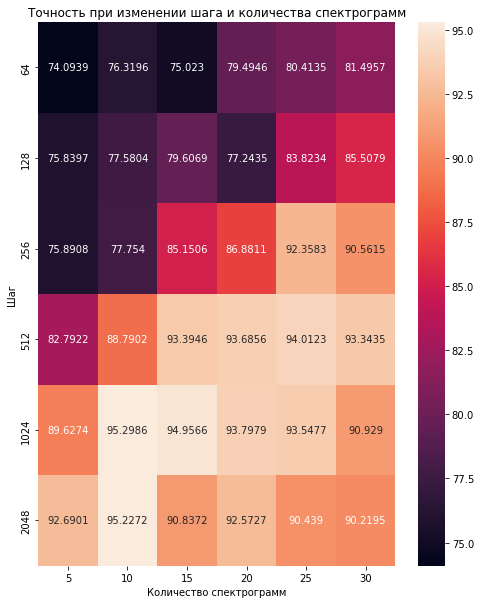

In [29]:
test_acc_mtx = np.zeros((len(step),len(num_frame)))
p = 0
for s in range(len(step)):
    for f in range(len(num_frame)):
        test_acc_mtx[s][f] = tests_acc[p]
        p+=1
plt.figure(figsize=(8, 10))
sns.heatmap(test_acc_mtx, xticklabels=num_frame, yticklabels=step, 
            annot=True, fmt='g')
plt.title('Точность при изменении шага и количества спектрограмм')
plt.xlabel('Количество спектрограмм')
plt.ylabel('Шаг')

Лучшая точность $(95.2986 \%)$ соответствует $10$ спектрограммам и шагу $1024$.

In [30]:
for k in range(len(params_s_f)):
    print(k, params_s_f[k],tests_acc[k])

0 (64, 5) 74.09392547217968
1 (64, 10) 76.31955079122001
2 (64, 15) 75.02297090352221
3 (64, 20) 79.49464012251148
4 (64, 25) 80.4134762633997
5 (64, 30) 81.49566105155691
6 (128, 5) 75.83971413986728
7 (128, 10) 77.58039816232771
8 (128, 15) 79.60694231750894
9 (128, 20) 77.24349157733538
10 (128, 25) 83.82337927514037
11 (128, 30) 85.50791220010208
12 (256, 5) 75.89076059213885
13 (256, 10) 77.75395610005104
14 (256, 15) 85.15058703420112
15 (256, 20) 86.88106176620724
16 (256, 25) 92.3583460949464
17 (256, 30) 90.56151097498724
18 (512, 5) 82.79224093925473
19 (512, 10) 88.79019908116386
20 (512, 15) 93.3945890760592
21 (512, 20) 93.68555385400714
22 (512, 25) 94.01225114854518
23 (512, 30) 93.34354262378764
24 (1024, 5) 89.62736089841756
25 (1024, 10) 95.29862174578867
26 (1024, 15) 94.95661051556917
27 (1024, 20) 93.7978560490046
28 (1024, 25) 93.54772843287391
29 (1024, 30) 90.92904543134253
30 (2048, 5) 92.69014803471158
31 (2048, 10) 95.22715671260848
32 (2048, 15) 90.837161817

In [31]:
k_max = np.argmax(np.array(tests_acc))
k_max

25

In [32]:
params_s_f[k_max][0],params_s_f[k_max][1]

(1024, 10)

In [33]:
train_ds = []
val_ds = []
test_ds = []

spectrogram_ds = waveform_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
spectrogram_ds = spectrogram_ds.map(lambda x, y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files,params_s_f[k_max][0],params_s_f[k_max][1])
test_ds = preprocess_dataset(test_ds,params_s_f[k_max][0],params_s_f[k_max][1])

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [34]:
test_audio = []
test_labels = []
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [45]:
history_ = histories[k_max]
model_ = models[k_max]
metrics = history_.history

y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true) / len(y_true) * 100
test_acc

95.29862174578867

[Text(0.5, 0, 'Номер эпохи'),
 Text(0, 0.5, 'Точность'),
 Text(0.5, 1.0, 'Точность тренировочная/проверочная')]

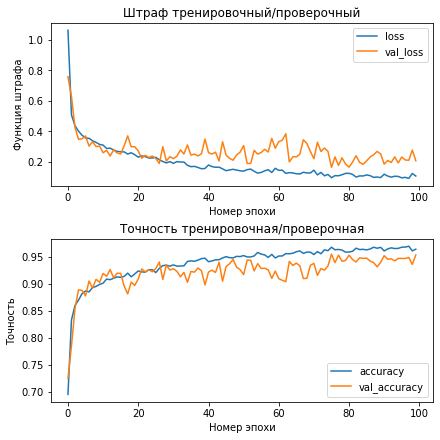

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), constrained_layout=True)
axes[0].plot(history_.epoch, metrics['loss'], metrics['val_loss'])
axes[0].legend(['loss', 'val_loss'])
axes[0].set(xlabel='Номер эпохи', ylabel='Функция штрафа', title=f'Штраф тренировочный/проверочный')

axes[1].plot(history_.epoch, metrics['accuracy'], metrics['val_accuracy'])
axes[1].legend(['accuracy', 'val_accuracy'])
axes[1].set(xlabel='Номер эпохи', ylabel='Точность', title=f'Точность тренировочная/проверочная')

Переобучение все еще наблюдается.

In [47]:
y_pred = np.argmax(model_.predict(test_audio), axis=1)
y_true = test_labels

In [48]:
y_true.shape

(19590,)

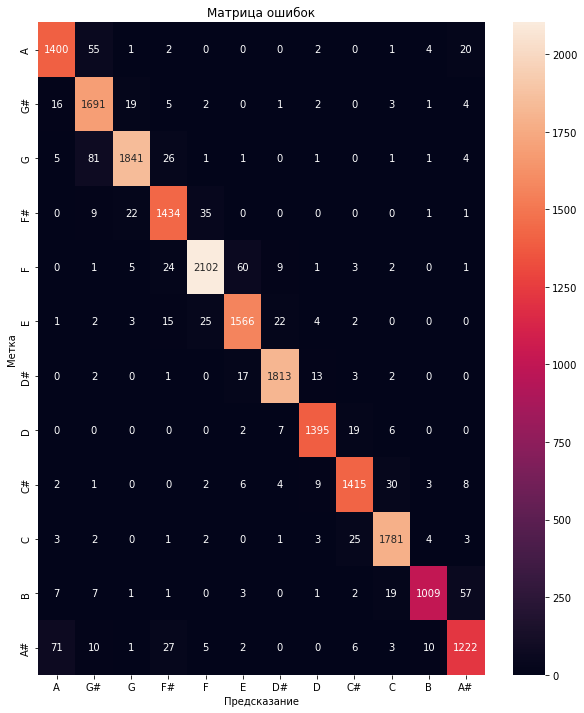

In [49]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 12))
sns.heatmap(confusion_mtx, xticklabels=notes, yticklabels=notes, 
            annot=True, fmt='g')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.title('Матрица ошибок')
plt.show()

In [50]:
sample_file = data_dir/'E/arpeg-CMaj-060BPM-leg_2.wav'
print('Sample file:', sample_file)
files_ds = tf.data.Dataset.from_tensor_slices([str(sample_file)])
output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
output_ds = output_ds.filter(without_zero_len) 
output_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id(x,y,params_s_f[k_max][0]), num_parallel_calls=AUTOTUNE)
sample_ds = output_ds.map(lambda x,y: get_spectrogram_and_label_id_lim(x,y,params_s_f[k_max][1]))

Sample file: D:\magistracy\diplom\records_cut\E\arpeg-CMaj-060BPM-leg_2.wav


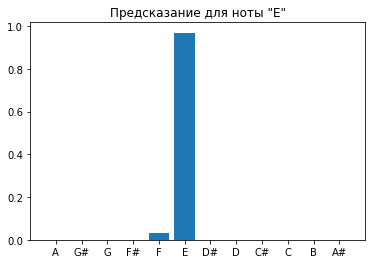

In [51]:
for spectrogram, label in sample_ds.batch(1):
    prediction = model_(spectrogram)
    plt.bar(notes, prediction[0])
    t = 'Предсказание для ноты "'+ notes[label[0]]+'"'
    plt.title(t)
    plt.show()


In [53]:
# Сохраняем модель
model_.save(r"D:\magistracy\diplom\model\model_3.h5")